In [1]:
from tqdm.autonotebook import tqdm

/home/calsaverini/.venvs/survival/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import pandas as pd
import numpy as np
import pycm

from xgboost import XGBClassifier
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import label_binarize, QuantileTransformer
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import logging

/home/calsaverini/.venvs/survival/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [4]:
raw_features = pd.read_parquet("../data/preprocessed/features.parquet").head(10000)
targets = pd.read_parquet('../data/preprocessed/targets.parquet').head(10000)

raw_features = raw_features.loc[targets.waiting_time.fillna(10) > 0]
targets = targets.loc[targets.waiting_time.fillna(10) > 0]

In [5]:
categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
    'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 'fst_sale_in_black_friday_days'
]

In [6]:
def train_target_encoding(raw_feature, target, pseudocount):
    global_mean = target.mean()
    
    # Compute the number of values and the mean of each group
    total_counts = target.groupby(raw_feature).agg('count')
    positive_counts = target.groupby(raw_feature).agg('sum')
    
    # pseudo-posterior parameters    
    avg_rate = (positive_counts + pseudocount * global_mean) / (total_counts + pseudocount)
    
    return pd.DataFrame({
        'avg_rate': avg_rate, 
        'confidence': np.log((1 + total_counts) / pseudocount)
    })

def calculate_target_encoding(feature_name, train_raw_features, test_raw_features, train_target, pseudocount):
    encoding = train_target_encoding(train_raw_features.loc[:, feature_name], train_target, pseudocount)
    col_names = [f'avg_rate_{feature_name}', f'confidence_{feature_name}']
    train_encoding = encoding.reindex(train_raw_features.loc[:, feature_name]).rename(columns=lambda c: f'{c}_{feature_name}')
    test_encoding = encoding.reindex(test_raw_features.loc[:, feature_name]).rename(columns=lambda c: f'{c}_{feature_name}')    
    train_encoding.index = train_raw_features.index
    test_encoding.index = test_raw_features.index
    return train_encoding, test_encoding

def apply_target_encoding(feature_names, train_raw_features, test_raw_features, train_target, pseudocount):
    for feature_name in feature_names:
        train_encoding, test_encoding = calculate_target_encoding(feature_name, train_raw_features, test_raw_features, train_target, pseudocount)
        train_raw_features = train_raw_features.join(train_encoding).drop(columns=[feature_name])
        test_raw_features = test_raw_features.join(test_encoding).drop(columns=[feature_name])
    return train_raw_features, test_raw_features

In [7]:
raw_features.loc[:, categorical_columns].nunique()

partner    51
device      4
gender      2
state      27
channel    24
dtype: int64

In [8]:
raw_features = pd.get_dummies(raw_features, columns=["device", "gender"], drop_first=True)
raw_features.head()

,channel,partner,age,state,has_marketplace,has_crossdocking,has_private_label,has_brands,gmv,days_since_last_bf,device_APP IOS,device_DESKTOP,device_M+T SITE,gender_male
0,EXCHANGED,EXCHANGED,30,sao_paulo,1,0,0,0,79.90,209.0,0,0,0,0
1,DIRECT,UNKNOWN,61,parana,0,0,0,1,160.00,160.0,0,1,0,0
3,CRM - EMAIL,EMAIL_TRANSACIONAL,25,minas_gerais,0,0,0,1,302.95,364.0,0,0,1,0
4,CRM - EMAIL,EMAIL_TRANSACIONAL,29,sao_paulo,0,0,0,1,99.00,155.0,0,1,0,1
5,CRM - EMAIL,EMAIL_TRANSACIONAL,33,rio_de_janeiro,0,0,1,1,119.89,230.0,0,1,0,0


In [9]:
y = (targets.waiting_time < 30).astype(int)

In [10]:
raw_train, raw_test, y_train, y_test = train_test_split(raw_features, y)

In [11]:
X_train, X_test = apply_target_encoding(['partner', 'state', 'channel'], raw_train, raw_test, y, 1000)

In [12]:
X_train.head().T

,4692,7886,7446,8739,315
age,29.000000,23.000000,42.000000,50.000000,52.000000
has_marketplace,0.000000,0.000000,0.000000,0.000000,0.000000
has_crossdocking,0.000000,0.000000,0.000000,0.000000,0.000000
has_private_label,0.000000,0.000000,0.000000,1.000000,0.000000
has_brands,1.000000,1.000000,1.000000,1.000000,1.000000
gmv,49.990000,313.900000,89.990000,189.000000,149.900000
days_since_last_bf,297.000000,249.000000,339.000000,139.000000,285.000000
device_APP IOS,0.000000,0.000000,0.000000,0.000000,0.000000
device_DESKTOP,1.000000,0.000000,1.000000,1.000000,0.000000
device_M+T SITE,0.000000,1.000000,0.000000,0.000000,0.000000


In [13]:
continuous_cols = [
    "age", "gmv", "days_since_last_bf", "avg_rate_partner", "confidence_partner",
    "avg_rate_state", "confidence_state", "avg_rate_channel", "confidence_channel"
]

In [14]:
qt = QuantileTransformer()
qt.fit(X_train.loc[:, continuous_cols])

X_train.loc[:, continuous_cols] = qt.transform(X_train.loc[:, continuous_cols])
X_test.loc[:, continuous_cols] = qt.transform(X_test.loc[:, continuous_cols])

In [15]:
HYPERPARAMETER_SPACE = [
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 1.0, "uniform", name='learning_rate'),
    Real(0.1, 10, "log-uniform", name='gamma'),    
    Real(0.05, 1, name='subsample'),
    Real(0.05, 1, name='colsample_bytree'),
#     Integer(2, 6, name='max_depth'),
#     Integer(100, 200, name="n_estimators"),
    Real(0.01, 0.99, name="base_score"),
#     Real(0.9, 1,0, name="scale_pos_weight"),
    Real(0, 5, name="reg_alpha"),
    Real(0, 5, name="reg_lambda"),
]

HYPERPARAMETER_NAMES = [dim.name for dim in HYPERPARAMETER_SPACE]

In [16]:
RANDOM_STATE = 939568576
TREE_METHOD = 'hist'#'exact'
NUM_PROCESSORS = 8
NUM_CROSS_VALIDATION_STEPS = 1
NUM_GP_OPTIMIZATION_STEPS = 1

In [17]:
def get_logger(name):
    logger = logging.getLogger(name)
    formatter = logging.Formatter('[%(asctime)s] %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger

logger = get_logger(__name__)

In [18]:
def train_model(X, y, **kwargs):
    model = XGBClassifier(
        max_depth=5,
        n_estimators=1000,
        scale_pos_weight=1,
        random_state=RANDOM_STATE,
        tree_method=TREE_METHOD,
        n_jobs=NUM_PROCESSORS,
        **kwargs,
    )
    model.fit(X, y)
    return model

def evaluate_model(X, y, **kwargs):
    roc_auc = []
    for _ in range(NUM_CROSS_VALIDATION_STEPS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        model = train_model(X_train, y_train, **kwargs)
        score = model.predict_proba(X_test)
        #total_correlation = np.sqrt(1 - np.exp(-2 * mutual_info_classif(score, y_test)))
        log_like = np.log(score[range(y_test.size), y_test]).mean()
        roc_auc.append(log_like)
    logger.info(f"Values: {roc_auc}")
    return np.mean(roc_auc)


def train_optimized_model(X, y):
        
    @use_named_args(HYPERPARAMETER_SPACE)
    def loss(**kwargs):
        return -evaluate_model(X, y, **kwargs)

    def get_optimization_callback():
        message = "Hyperparameter optimization iteration {:d}/{:d}. Current: {:5.3f}. Best: {:5.3f}."
            #" Parameters:\n{}"
        def callback(res):          
            current_value = -res.func_vals[-1]
            best_value = -res.func_vals.min()            
            current_params = pd.Series(dict(zip(
                HYPERPARAMETER_NAMES, 
                map(fix_type, res.x)
            )))
            logger.info(message.format(
                len(res.func_vals),
                NUM_GP_OPTIMIZATION_STEPS,
                current_value,
                best_value,
                #current_params
            ))

        return callback

    def fix_type(x):
        if isinstance(x, bool):
            return x
        elif np.issubdtype(np.dtype(x), np.int_):
            return int(x)
        elif np.issubdtype(np.dtype(x), np.float_):
            return float(x)

    logger.info("Will start hyperparameter optimization.")
    optimization_results = gp_minimize(
        loss,
        HYPERPARAMETER_SPACE,
        n_random_starts=max(1, min(10, int(NUM_GP_OPTIMIZATION_STEPS / 2))),
        n_calls=NUM_GP_OPTIMIZATION_STEPS,
        random_state=RANDOM_STATE,
        callback=get_optimization_callback(),
    )
    logger.info("Finished hyperparameter optimization.")
    best_parameters = dict(
        zip(HYPERPARAMETER_NAMES, map(fix_type, optimization_results.x))
    )
    logger.info("Starting training of final model.")
    return train_model(X, y, verbosity=1, **best_parameters)


In [19]:
%time best_model = train_optimized_model(X_train, y_train)

[2019-06-14 16:31:54,384] Will start hyperparameter optimization.
[2019-06-14 16:32:09,452] Values: [-0.42563972]
[2019-06-14 16:32:09,594] Hyperparameter optimization iteration 1/1. Current: -0.426. Best: -0.426.
[2019-06-14 16:32:09,595] Finished hyperparameter optimization.
[2019-06-14 16:32:09,595] Starting training of final model.


CPU times: user 3min 25s, sys: 1.42 s, total: 3min 26s
Wall time: 31 s


In [20]:
y_pred = best_model.predict(X_test)
s_pred = best_model.predict_proba(X_test)

print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2213
           1       0.48      0.18      0.26       287

    accuracy                           0.88      2500
   macro avg       0.69      0.58      0.60      2500
weighted avg       0.85      0.88      0.86      2500



In [21]:
cm = pycm.ConfusionMatrix(actual_vector=y_test.values, predict_vector=y_pred)
cm.print_normalized_matrix()

Predict       0             1             
Actual
0             0.97469       0.02531       

1             0.8223        0.1777        




In [22]:
fpr, tpr, roc_thres = skmetrics.roc_curve(y_test, s_pred[:, 1])

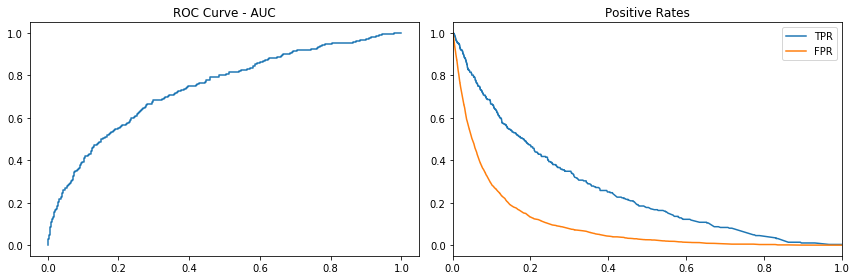

In [23]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_title(f"ROC Curve - AUC")
ax.plot(fpr, tpr)

ax = fig.add_subplot(122)
ax.set_title("Positive Rates")
ax.plot(roc_thres, tpr, label="TPR")
ax.plot(roc_thres, fpr, label="FPR")
ax.set_xlim(0, 1)
ax.legend()

fig.tight_layout()

In [24]:
total_correlation = np.sqrt(1 - np.exp(-2 * mutual_info_classif(s_pred, y_test))).min()
print(total_correlation)

0.27078666627745057


In [25]:
# skmetrics.roc_auc_score(label_binarize(y_test, range(len(code2period))), s_pred, average='micro')

In [26]:
# skmetrics.roc_auc_score(label_binarize(y_test, range(len(code2period))), s_pred, average='macro')

In [27]:
n_points = min(100, np.unique(s_pred[:, 1]).shape[0])

In [28]:
thresholds = np.linspace(s_pred.min(), s_pred[:, 1].max()*0.999, n_points)

metrics = pd.DataFrame([
    skmetrics.precision_recall_fscore_support(y_test, (s_pred[:, 1] >= threshold), average='binary')
    for threshold in thresholds
], columns=["precision", "recall", "f1", "support"], index=thresholds)

optimal_threshold = metrics.f1.idxmax()


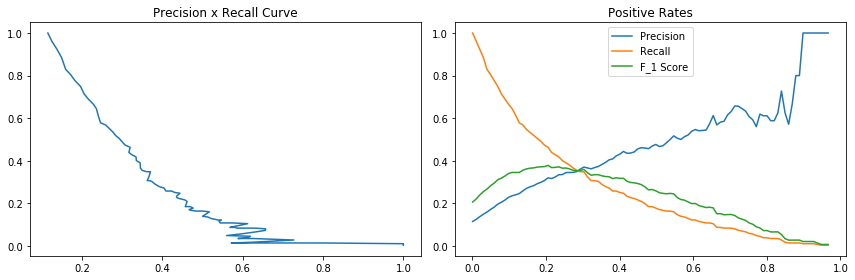

In [29]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_title("Precision x Recall Curve")
ax.plot(metrics.precision, metrics.recall)

ax = fig.add_subplot(122)
ax.set_title("Positive Rates")
ax.plot(metrics.index, metrics.precision, label="Precision")
ax.plot(metrics.index, metrics.recall, label="Recall")
ax.plot(metrics.index, metrics.f1, label="F_1 Score")
# ax.axvline(optimal_threshold)
ax.legend()

fig.tight_layout()

In [37]:
metrics.loc[optimal_threshold].to_dict()

{'precision': 0.31971153846153844,
 'recall': 0.4634146341463415,
 'f1': 0.3783783783783784,
 'support': None}

In [30]:
optimal_threshold = metrics.f1.argmax()
print(metrics.loc[optimal_threshold])
y_pred = (s_pred[:, 1] > optimal_threshold).astype(int)

precision    0.319712
recall       0.463415
f1           0.378378
support          None
Name: 0.20534177158188752, dtype: object


/home/calsaverini/.venvs/survival/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


In [31]:
print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2213
           1       0.32      0.46      0.38       287

    accuracy                           0.83      2500
   macro avg       0.62      0.67      0.64      2500
weighted avg       0.86      0.83      0.84      2500



In [32]:
#best_model.save_artifact("./within_year_model.pred")

In [33]:
pd.Series(dict(zip(X_train.columns, best_model.feature_importances_))).sort_values(ascending=False).head(20)

avg_rate_channel      0.085517
confidence_channel    0.084978
confidence_partner    0.084014
device_M+T SITE       0.072013
device_APP IOS        0.067572
avg_rate_partner      0.066390
days_since_last_bf    0.057399
confidence_state      0.056891
gender_male           0.055036
age                   0.054701
gmv                   0.054255
avg_rate_state        0.054036
has_brands            0.052054
has_private_label     0.052003
device_DESKTOP        0.044058
has_marketplace       0.035823
has_crossdocking      0.023260
dtype: float64

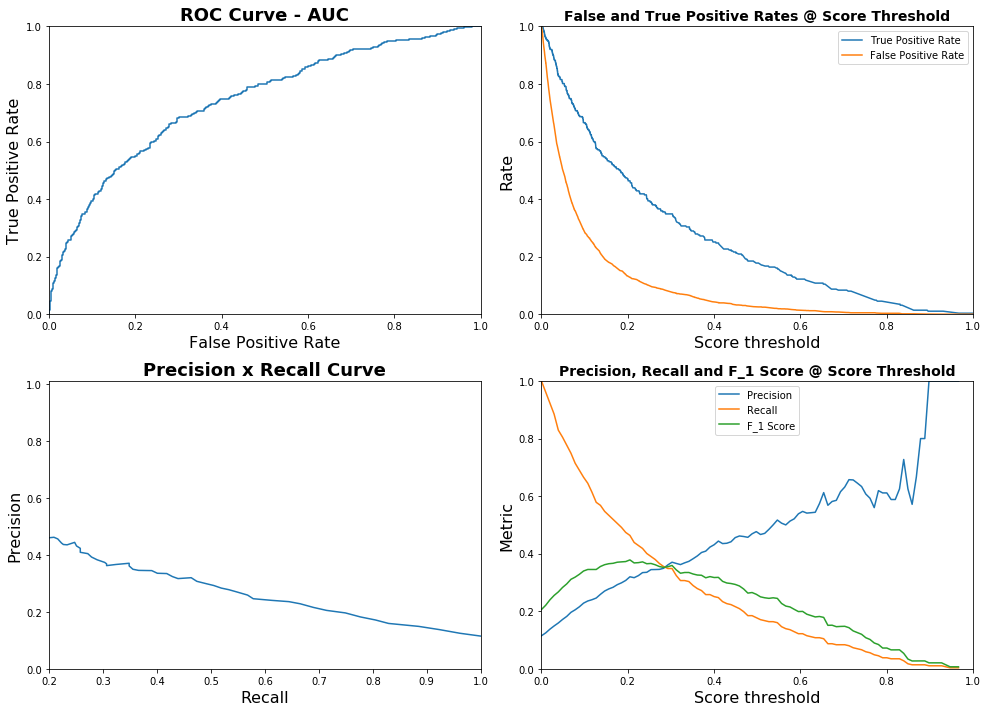

In [34]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(221)
ax.set_title(f"ROC Curve - AUC", fontdict={'size': 18, 'fontweight': 'bold'})
ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate", fontdict={'size': 16})
ax.set_ylabel("True Positive Rate", fontdict={'size': 16})
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax = fig.add_subplot(222)
ax.set_title("False and True Positive Rates @ Score Threshold", fontdict={'size': 14, 'fontweight': 'bold'})
ax.plot(roc_thres, tpr, label="True Positive Rate")
ax.plot(roc_thres, fpr, label="False Positive Rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Score threshold", fontdict={'size': 16})
ax.set_ylabel("Rate", fontdict={'size': 16})
ax.legend()

ax = fig.add_subplot(223)
ax.set_title("Precision x Recall Curve", fontdict={'size': 18, 'fontweight': 'bold'})
ax.plot(metrics.recall, metrics.precision)
ax.set_xlabel("Recall", fontdict={'size': 16})
ax.set_ylabel("Precision", fontdict={'size': 16})
ax.set_xlim(0.2, 1)
ax.set_ylim(0, 1.01)


ax = fig.add_subplot(224)
ax.set_title("Precision, Recall and F_1 Score @ Score Threshold", fontdict={'size': 14, 'fontweight': 'bold'})
ax.plot(metrics.index, metrics.precision, label="Precision")
ax.plot(metrics.index, metrics.recall, label="Recall")
ax.plot(metrics.index, metrics.f1, label="F_1 Score")
ax.set_xlabel("Score threshold", fontdict={'size': 16})
ax.set_ylabel("Metric", fontdict={'size': 16})
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

fig.tight_layout()